# A/B TESTING WITH MACHINE LEARNING

## Loading Libraries we will use in the project

In [ ]:
#importing libraries for the project
import pandas as pd
import sklearn.utils
from matplotlib import pyplot
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [3]:
# loading data using pandas
exposed_data=pd.read_csv('/content/Exposed_group_data.csv')
control_data=pd.read_csv('/content/control_group_data.csv')

In [4]:
#
exposed_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,004940f5-c642-417a-8fd2-c8e5d989f358,exposed,2020-07-04,0,Generic Smartphone,6,Chrome Mobile WebView,0,0
4,006b9c6e-5f5d-4385-a811-ff20a24b30ac,exposed,2020-07-06,8,Samsung SM-G973F,6,Chrome Mobile WebView,0,0


In [5]:
exp_data=(exposed_data.groupby('date')
      .agg(pageviews=('yes','count'),yes=('yes','sum'),no=('no','sum'),hours=('hour','sum'))
      .reset_index()
       )

In [6]:
exp_data

,date,pageviews,yes,no,hours
0,2020-07-03,470,43,49,3986
1,2020-07-04,477,46,45,5114
2,2020-07-05,528,35,39,5506
3,2020-07-06,294,23,25,1717
4,2020-07-07,257,22,24,2767
5,2020-07-08,714,58,61,10899
6,2020-07-09,728,55,64,8177
7,2020-07-10,538,26,42,4765


In [7]:
control_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
1,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
2,0027ce48-d3c6-4935-bb12-dfb5d5627857,control,2020-07-03,15,Samsung SM-G960F,6,Facebook,0,0
3,002e308b-1a07-49d6-8560-0fbcdcd71e4b,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
4,00393fb9-ca32-40c0-bfcb-1bd83f319820,control,2020-07-09,5,Samsung SM-G973F,6,Facebook,0,0


In [8]:
cont_data=(control_data.groupby('date')
      .agg(pageviews=('yes','count'),yes=('yes','sum'),no=('no','sum'),hours=('hour','sum'))
      .reset_index()
       )

In [9]:
cont_data

,date,pageviews,yes,no,hours
0,2020-07-03,1545,104,129,23177
1,2020-07-04,426,30,38,4164
2,2020-07-05,362,17,26,3949
3,2020-07-06,196,12,14,1104
4,2020-07-07,223,16,21,2312
5,2020-07-08,484,27,31,7489
6,2020-07-09,480,30,35,5552
7,2020-07-10,355,28,28,3137


## Number summaries and basic investigations

In [313]:
exposed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   4006 non-null   object
 1   experiment   4006 non-null   object
 2   date         4006 non-null   object
 3   hour         4006 non-null   int64 
 4   device_make  4006 non-null   object
 5   platform_os  4006 non-null   int64 
 6   browser      4006 non-null   object
 7   yes          4006 non-null   int64 
 8   no           4006 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 281.8+ KB


In [314]:
control_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   4071 non-null   object
 1   experiment   4071 non-null   object
 2   date         4071 non-null   object
 3   hour         4071 non-null   int64 
 4   device_make  4071 non-null   object
 5   platform_os  4071 non-null   int64 
 6   browser      4071 non-null   object
 7   yes          4071 non-null   int64 
 8   no           4071 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 286.4+ KB


In [315]:
exposed_data.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [316]:
control_data.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

## Data wrangling

In [10]:
data_total1 = pd.concat([control_data, exposed_data])
data_total1.sample(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
3211,cbd3b031-39f6-4fc0-914c-7eefff97abda,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
1228,508ccd3a-35a8-4e45-a77d-d9091ab86cdb,exposed,2020-07-05,8,Generic Smartphone,6,Chrome Mobile,0,1
657,2c085ba3-2fae-446d-8a30-8c359b11adcc,exposed,2020-07-04,14,Generic Smartphone,6,Chrome Mobile,0,0
3107,c5a88e96-5ae7-4088-bf70-5f8d14838459,exposed,2020-07-05,4,Samsung SM-N960F,6,Facebook,0,0
790,34e77b7b-3883-40ed-aa6c-431693720856,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,0
116,078947a9-2040-4f77-ba3e-b6b7df1f1434,exposed,2020-07-08,20,Generic Smartphone,6,Chrome Mobile WebView,0,0
2553,a4015637-4710-4ea6-b9dc-f857eeeeec43,exposed,2020-07-08,19,Generic Smartphone,6,Chrome Mobile,1,0
2208,8b5d5324-565f-4a15-bb94-215aba170123,control,2020-07-09,17,Samsung SM-A505FN,6,Facebook,0,0
174,0a431ec7-b60a-44a2-8393-529489c6ce7f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
2949,bba19c04-437d-4be9-affd-a3bf913767f7,exposed,2020-07-09,8,Generic Smartphone,6,Chrome Mobile,0,0


In [11]:
data_total1['experiment'] = pd.factorize(data_total1.experiment)[0]

In [12]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
data_total1['device_make']= label_encoder.fit_transform(data_total1['device_make']) 

In [14]:
# Encode labels in column 'species'. 
data_total1['browser']= label_encoder.fit_transform(data_total1['browser']) 

In [16]:
# Encode labels in column 'species'. 
data_total1['date']= label_encoder.fit_transform(data_total1['date']) 

In [17]:
data_total1

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,00187412-2932-4542-a8ef-3633901c98d9,0,0,15,137,6,6,0,0
1,001a7785-d3fe-4e11-a344-c8735acacc2c,0,0,15,46,6,2,0,0
2,0027ce48-d3c6-4935-bb12-dfb5d5627857,0,0,15,177,6,6,0,0
3,002e308b-1a07-49d6-8560-0fbcdcd71e4b,0,0,15,46,6,2,0,0
4,00393fb9-ca32-40c0-bfcb-1bd83f319820,0,6,5,184,6,6,0,0
...,...,...,...,...,...,...,...,...,...
4001,ffbc02cb-628a-4de5-87fc-5d76b7d796e5,1,6,17,46,6,2,0,0
4002,ffc594ef-756c-4d24-a310-0d8eb4e11eb7,1,2,1,171,6,3,0,0
4003,ffdfdc09-48c7-4bfb-80f8-ec1eb633602b,1,0,4,46,6,2,0,1
4004,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,1,2,7,46,6,2,0,0


In [29]:
# Getting the features we need
data=data_total1[['hour','platform_os','date','browser','experiment','yes','no']]

In [30]:
# Splitting the data according to features and the target feature
X1 = data.drop('yes', axis=1) #prediction features
y1 = data['yes'] #target feature

In [31]:
# Splitting our dataset into training and testing dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20) #training set 80% and test set 20%

## **K-Fold Cross-validation**

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.
Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.
In this section, we will use it to determine the performance of these models on the BIO data:


*   Logistic Regression
*   Decision Tree
*   XGBoost



## 1. Logistic Regression

In [32]:
# Applying the K-fol Cross validation on logistic Regression model
regressor=LogisticRegression(random_state=None)
regressor.fit(X1_train,y1_train) 
scores=cross_val_score(estimator=regressor,X=X1_train,y=y1_train,cv=5,scoring='accuracy')
print(scores)
print('Mean LogisticRegression score :',scores.mean())

[0.92807425 0.92879257 0.92879257 0.92801858 0.92801858]
Mean LogisticRegression score : 0.9283393073922694


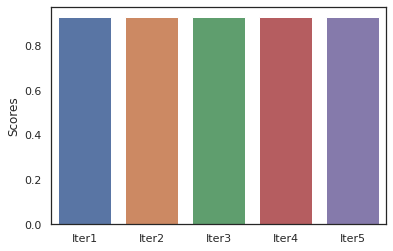

In [33]:
scores1 = pd.DataFrame(scores,columns=['Scores']) #storing the results into pandas dataframe
#plotting the accuracy score for the  different iteration
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['Iter1','Iter2','Iter3','Iter4','Iter5'],y="Scores",data=scores1)
plt.show()
sns.set()

## Logistic Regression Feature importance
Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.
Feature importance scores play an important role in a predictive modeling project, including providing insight into the data, insight into the model, and the basis for dimensionality reduction and feature selection that can improve the efficiency and effectiveness of a predictive model on the problem.
In this section we are going to calcualte the importance of the features in our BIo data in logistic regression

In [34]:
#feature coefficients
regressor.fit(X1 / np.std(X1, 0), y1)
print(regressor.coef_)

[[ 0.05529597  0.42625459 -0.07073878  0.06806557  0.1071433  -1.38768786]]


Feature: 0, Score: 0.00982
Feature: 1, Score: 1.64935
Feature: 2, Score: -0.02762
Feature: 3, Score: 0.01755
Feature: 4, Score: 0.21439
Feature: 5, Score: -2.97435


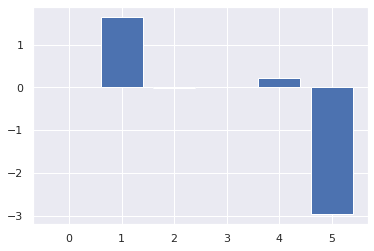

In [35]:
#plotting the feature importance
#The coefficients are both positive and negative.
# logistic regression for feature importance

# define the model
model = LogisticRegression()
# fit the model
model.fit(X1, y1)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## 2. Decision Tree

In [36]:
#Applying k-fold Cross validation on Decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X1_train,y1_train)
clf_scores=cross_val_score(estimator=clf,X=X1_train,y=y1_train,cv=5,scoring='accuracy')
print(clf_scores)
print('Mean clf score :',clf_scores.mean())

[0.91647332 0.91486068 0.91873065 0.91640867 0.91563467]
Mean clf score : 0.9164215985576059


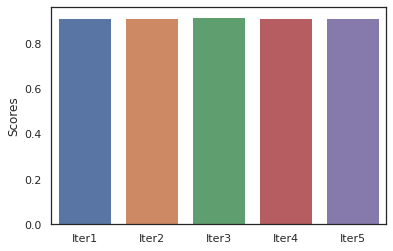

In [37]:
scores2 = pd.DataFrame(clf_scores,columns=['Scores']) # saving the results into pandas dataframe
 # plotting the scores
sns.set(style="white", rc={"lines.linewidth": 3})
sns.barplot(x=['Iter1','Iter2','Iter3','Iter4','Iter5'],y="Scores",data=scores2)
plt.show()
sns.set()

## Decision Tree Feature importance

Feature: 0, Score: 0.46119
Feature: 1, Score: 0.02111
Feature: 2, Score: 0.23677
Feature: 3, Score: 0.15795
Feature: 4, Score: 0.08260
Feature: 5, Score: 0.04038


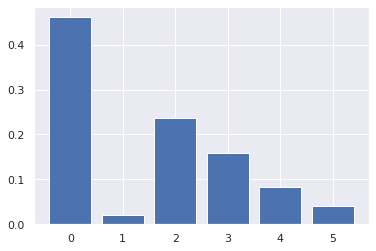

In [38]:


# calculating and plotting the feature importance

# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X1, y1)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [330]:

def dt_feature_importance(model,normalize=True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx,node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node]+=impurity[idx]*node_samples[idx]- \
                                   impurity[left_c[idx]]*node_samples[left_c[idx]]-\
                                   impurity[right_c[idx]]*node_samples[right_c[idx]]

    # Number of samples at the root node
    feature_importance/=node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance/=normalizer

    return feature_importance

In [ ]:
features = clf.tree_.feature[clf.tree_.feature>=0] # Feature number should not be negative, indicates a leaf node
sorted(zip(features,dt_feature_importance(clf,False)[features]),key=lambda x:x[1],reverse=True)

## 3. XGBoost

In [39]:

# k-fold cross validation evaluation of xgboost model
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=5, random_state=None)
results = cross_val_score(model, X1, y1, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)) # Percentage accuracy mean and standard deviation


Accuracy: 92.92% (1.15%)


## XGBoost Feature importance

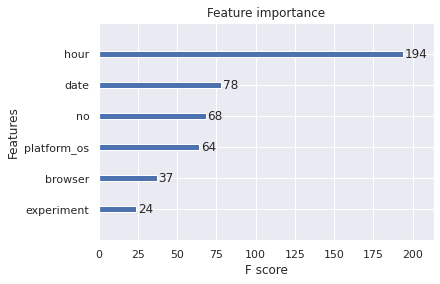

In [40]:
#Calculating the feature importance and plotting
# plot feature importance using built-in function

from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()
model.fit(X1, y1)
# plot feature importance
plot_importance(model)
pyplot.show()

## Loss function using the Validation set

Train: 0.067, Test: 0.063


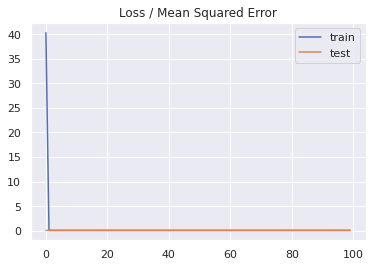

In [41]:

# mlp for regression with mse loss function
# define model
model = Sequential()
model.add(Dense(25, input_dim=6, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)
# fit model
history = model.fit(X1_train,y1_train, validation_data=(X1_test,y1_test), epochs=100, verbose=0)
# evaluate the model
train_mse = model.evaluate(X1_train, y1_train, verbose=0)
test_mse = model.evaluate(X1_test, y1_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()